In [16]:
!python data.py

In [17]:
!python training.py

Training: 100% 3000/3000 [00:22<00:00, 133.41it/s]


In [18]:
import pandas as pd
import matplotlib.pyplot as plt

losses_df = pd.read_csv("losses.csv")

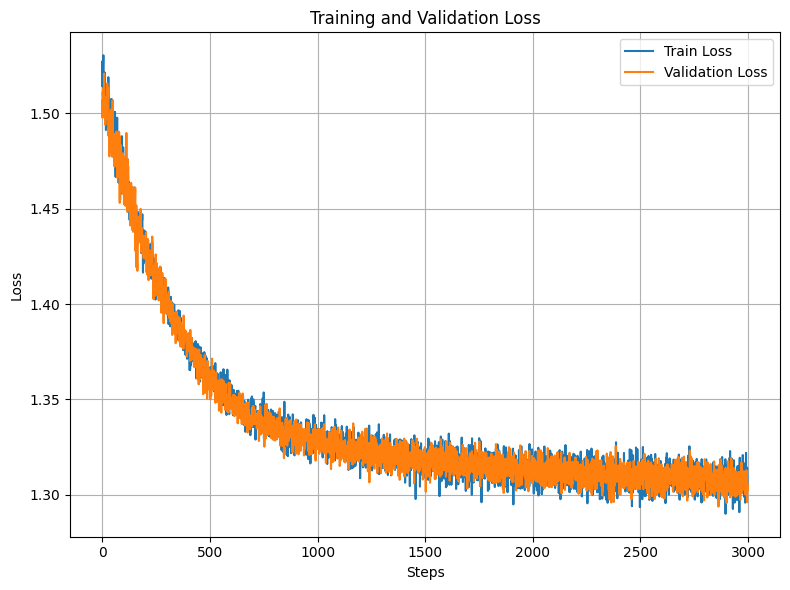

In [19]:
plt.figure(figsize=(8, 6))
plt.plot(losses_df['Step'], losses_df['Train Loss'], label="Train Loss")
plt.plot(losses_df['Step'], losses_df['Validation Loss'], label="Validation Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
from misc import *
from model import *
from training import *

model = ACGT_LM(d_model=D_MODEL, n_layers=N_LAYERS, n_heads=N_HEAD, block_size=BLOCK_SIZE).to(device)

# Load best model
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model = model.to(device)

# Sample sequences
generated_df = sample_sequences(model, n_generate=100, sequence_length=100, start_sequence="A", temperature=1.0)

In [21]:
generated_df.head()

,sequence
0,ACACAGACGTTTAAGTACGCACTACCAAGGTAGACTGGCGAGAGGA...
1,ACAGCAGAGCCCAGACTACCCCGTAGCGGGTACTCATACGGTTCGA...
2,ACGTAGTTACTCAGTCCCCACGGGCCATACTCGAACTACTGAGTGT...
3,ACACAGTTTGACACTACTAGACACTTGGCACTACACACCATAGTGC...
4,AATTTGGCTCACAGTAGCCCGCACAGGCGGAGATCTAGAGTCCGAC...


In [22]:
# Compute and print statistics

def compute_statistics(df_in):
    nucleotide_counts = {n: 0 for n in NUCLEOTIDES}
    transition_counts = {n: {m: 0 for m in NUCLEOTIDES} for n in NUCLEOTIDES}

    for seq in df_in["sequence"]:
        for i, n in enumerate(seq):
            nucleotide_counts[n] += 1
            if i > 0:
                transition_counts[seq[i - 1]][n] += 1

    total = sum(nucleotide_counts.values()) or 1
    marginal_df = pd.DataFrame(
        {n: nucleotide_counts[n] / total for n in NUCLEOTIDES},
        index=["marginal_probability"],
    ).T

    transition_df = pd.DataFrame(transition_counts).T
    transition_df = transition_df.div(transition_df.sum(axis=1).replace(0, 1), axis=0)

    return marginal_df.join(transition_df)

In [23]:
original_stats = compute_statistics(pd.read_pickle("data.pkl"))
generated_stats = compute_statistics(generated_df)

In [24]:
# Original Data Marginal and Conditional Probabilities

original_stats

,marginal_probability,A,C,G,T
A,0.2679,0.096386,0.399849,0.403238,0.100527
C,0.2670,0.301250,0.197802,0.310345,0.190603
G,0.2963,0.257416,0.248551,0.246505,0.247528
T,0.1688,0.505383,0.199761,0.193182,0.101675


In [25]:
# Generated Data Marginal and Conditional Probabilities

generated_stats

,marginal_probability,A,C,G,T
A,0.2731,0.088420,0.400666,0.407695,0.103219
C,0.2710,0.304429,0.208411,0.305545,0.181615
G,0.2903,0.286609,0.248348,0.230957,0.234087
T,0.1656,0.458716,0.215902,0.193272,0.132110
